In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ibrahimserouis99/one-piece-image-classifier

100% 2.53G/2.53G [01:42<00:00, 27.4MB/s]
100% 2.53G/2.53G [01:42<00:00, 26.6MB/s]


In [ ]:
from IPython.display import clear_output
! unzip '/content/one-piece-image-classifier.zip' -d '/content/one-piece-image-classifier'
clear_output()

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
dir='/content/one-piece-image-classifier/Data/Data'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [ ]:
train_transform = v2.Compose([v2.Resize([224,224]),v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
transform = v2.Compose([v2.Resize([224,224]), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

In [ ]:
import os
from PIL import Image
extensions = []
index = 0

for fldr in os.listdir(dir):
  sub_folder_path =  os.path.join(dir, fldr)
  for filee in os.listdir(sub_folder_path):
    file_path = os.path.join(sub_folder_path, filee)
    # print('** PATH: {} **'.format(file_path), end = '\Data', flush = True)
    # print(file_path)
    im  = Image.open(file_path)
    rgb_im = im.convert('RGBA')

In [ ]:
dataset=datasets.ImageFolder(dir,transform=train_transform)

In [ ]:
m=int(0.8*len(dataset))
n=len(dataset)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=[m,n-m])

In [ ]:
train_dataset[0]

(Image([[[0.3137, 0.3137, 0.3137,  ..., 0.3137, 0.3137, 0.3137],
         [0.3137, 0.3137, 0.3137,  ..., 0.3137, 0.3137, 0.3137],
         [0.3137, 0.3137, 0.3137,  ..., 0.3137, 0.3137, 0.3137],
         ...,
         [0.8314, 0.8353, 0.8353,  ..., 0.4471, 0.4510, 0.4510],
         [0.8039, 0.8157, 0.8314,  ..., 0.4471, 0.4471, 0.4471],
         [0.8039, 0.8157, 0.8314,  ..., 0.4471, 0.4471, 0.4471]],
 
        [[0.6196, 0.6196, 0.6196,  ..., 0.6196, 0.6196, 0.6196],
         [0.6196, 0.6196, 0.6196,  ..., 0.6196, 0.6196, 0.6196],
         [0.6196, 0.6196, 0.6196,  ..., 0.6196, 0.6196, 0.6196],
         ...,
         [0.9765, 0.9765, 0.9725,  ..., 0.7882, 0.7882, 0.7882],
         [0.9882, 0.9804, 0.9725,  ..., 0.7843, 0.7843, 0.7843],
         [0.9882, 0.9804, 0.9725,  ..., 0.7843, 0.7843, 0.7843]],
 
        [[0.9451, 0.9451, 0.9451,  ..., 0.9451, 0.9451, 0.9451],
         [0.9451, 0.9451, 0.9451,  ..., 0.9451, 0.9451, 0.9451],
         [0.9451, 0.9451, 0.9451,  ..., 0.9451, 0.9451, 

In [ ]:
len(test_dataset)

2348

In [ ]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

In [ ]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)

torch.Size([32, 3, 224, 224])


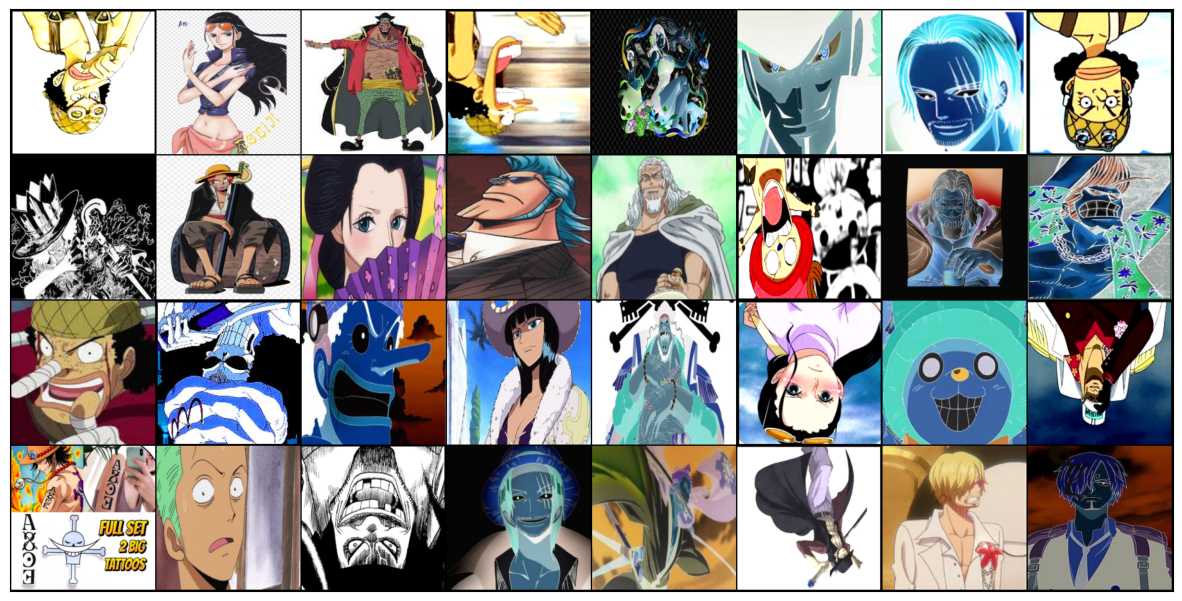

In [ ]:
show_batch(train_loader);

torch.Size([32, 3, 224, 224])


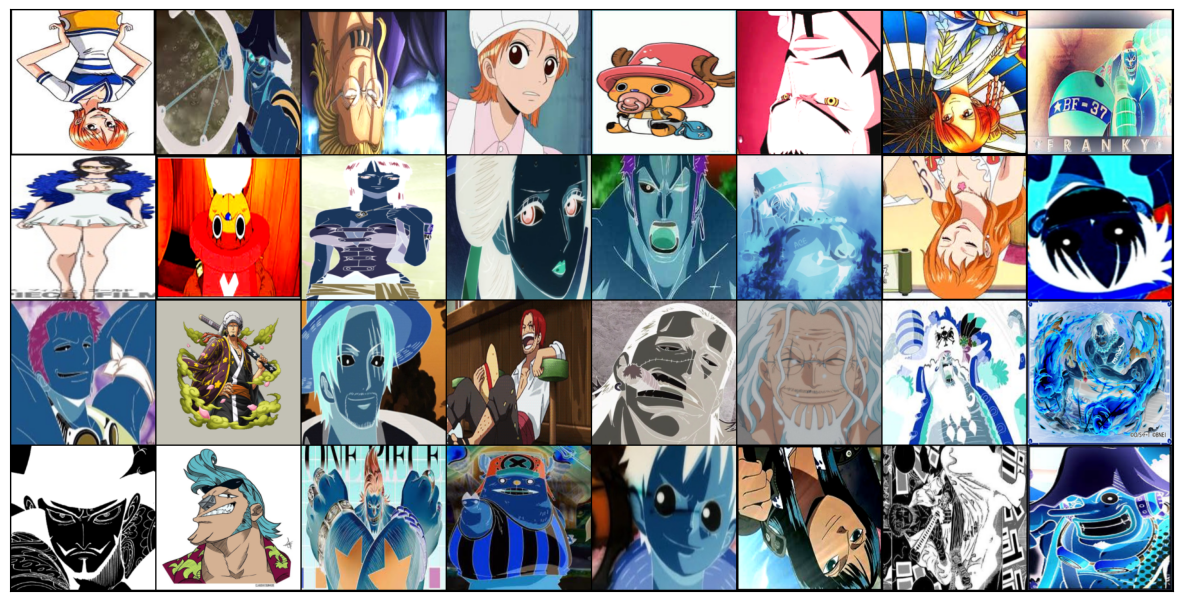

In [ ]:
show_batch(test_loader)

In [ ]:
import torchvision.models as models

In [ ]:
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
model.to(device);

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 21.4MB/s]


In [ ]:
! pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 576, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 56, 56]           --
│    │    └─Sequential: 3-4                        [1, 16, 56, 56]           744
│    └─InvertedResidual: 2-3                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-5                        [1, 24, 28, 28]           3,864
│    └─InvertedResidual: 2-4                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-6   

In [ ]:
model.classifier[3]=nn.Linear(1024,18)

In [ ]:
model.to(device);

In [ ]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 18]                   --
├─Sequential: 1-1                                  [1, 576, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 56, 56]           --
│    │    └─Sequential: 3-4                        [1, 16, 56, 56]           744
│    └─InvertedResidual: 2-3                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-5                        [1, 24, 28, 28]           3,864
│    └─InvertedResidual: 2-4                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-6   

In [ ]:
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
!pip install pytorch-ignite --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=18)}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [ ]:
trainer.run(train_loader, max_epochs=20)

  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 89.05 Сред. ошибка: 0.34511
Результат валидации - Эпоха: 1  Сред. точность: 85.35 Сред. ошибка: 0.49305


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 93.99 Сред. ошибка: 0.19990
Результат валидации - Эпоха: 2  Сред. точность: 89.74 Сред. ошибка: 0.32687


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 95.70 Сред. ошибка: 0.13279
Результат валидации - Эпоха: 3  Сред. точность: 92.04 Сред. ошибка: 0.26952


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 95.19 Сред. ошибка: 0.15362
Результат валидации - Эпоха: 4  Сред. точность: 91.31 Сред. ошибка: 0.30727


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 97.26 Сред. ошибка: 0.08706
Результат валидации - Эпоха: 5  Сред. точность: 93.40 Сред. ошибка: 0.22876


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.82 Сред. ошибка: 0.10416
Результат валидации - Эпоха: 6  Сред. точность: 92.72 Сред. ошибка: 0.24877


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 99.40 Сред. ошибка: 0.01858
Результат валидации - Эпоха: 7  Сред. точность: 96.72 Сред. ошибка: 0.11983


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 96.34 Сред. ошибка: 0.10856
Результат валидации - Эпоха: 8  Сред. точность: 91.91 Сред. ошибка: 0.31028


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.34 Сред. ошибка: 0.02294
Результат валидации - Эпоха: 9  Сред. точность: 97.10 Сред. ошибка: 0.13688


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 97.82 Сред. ошибка: 0.07474
Результат валидации - Эпоха: 10  Сред. точность: 93.78 Сред. ошибка: 0.23036


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.38 Сред. ошибка: 0.02076
Результат валидации - Эпоха: 11  Сред. точность: 96.68 Сред. ошибка: 0.11591


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 97.28 Сред. ошибка: 0.08263
Результат валидации - Эпоха: 12  Сред. точность: 92.72 Сред. ошибка: 0.27336


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 95.56 Сред. ошибка: 0.15176
Результат валидации - Эпоха: 13  Сред. точность: 90.37 Сред. ошибка: 0.36844


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 98.57 Сред. ошибка: 0.04832
Результат валидации - Эпоха: 14  Сред. точность: 95.27 Сред. ошибка: 0.17215


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 90.97 Сред. ошибка: 0.39455
Результат валидации - Эпоха: 15  Сред. точность: 86.29 Сред. ошибка: 0.63138


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 98.09 Сред. ошибка: 0.06953
Результат валидации - Эпоха: 16  Сред. точность: 93.91 Сред. ошибка: 0.21682


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 98.52 Сред. ошибка: 0.04438
Результат валидации - Эпоха: 17  Сред. точность: 96.00 Сред. ошибка: 0.15614


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 97.62 Сред. ошибка: 0.07866
Результат валидации - Эпоха: 18  Сред. точность: 93.70 Сред. ошибка: 0.25794


  0%|          | 1/294 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 98.27 Сред. ошибка: 0.06828


2023-12-18 13:59:23,282 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 19  Сред. точность: 94.68 Сред. ошибка: 0.20923


2023-12-18 13:59:34,670 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 'Subset' object has no attribute 'classes'


State:
	iteration: 5586
	epoch: 19
	epoch_length: 294
	max_epochs: 20
	output: 0.0003032273380085826
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

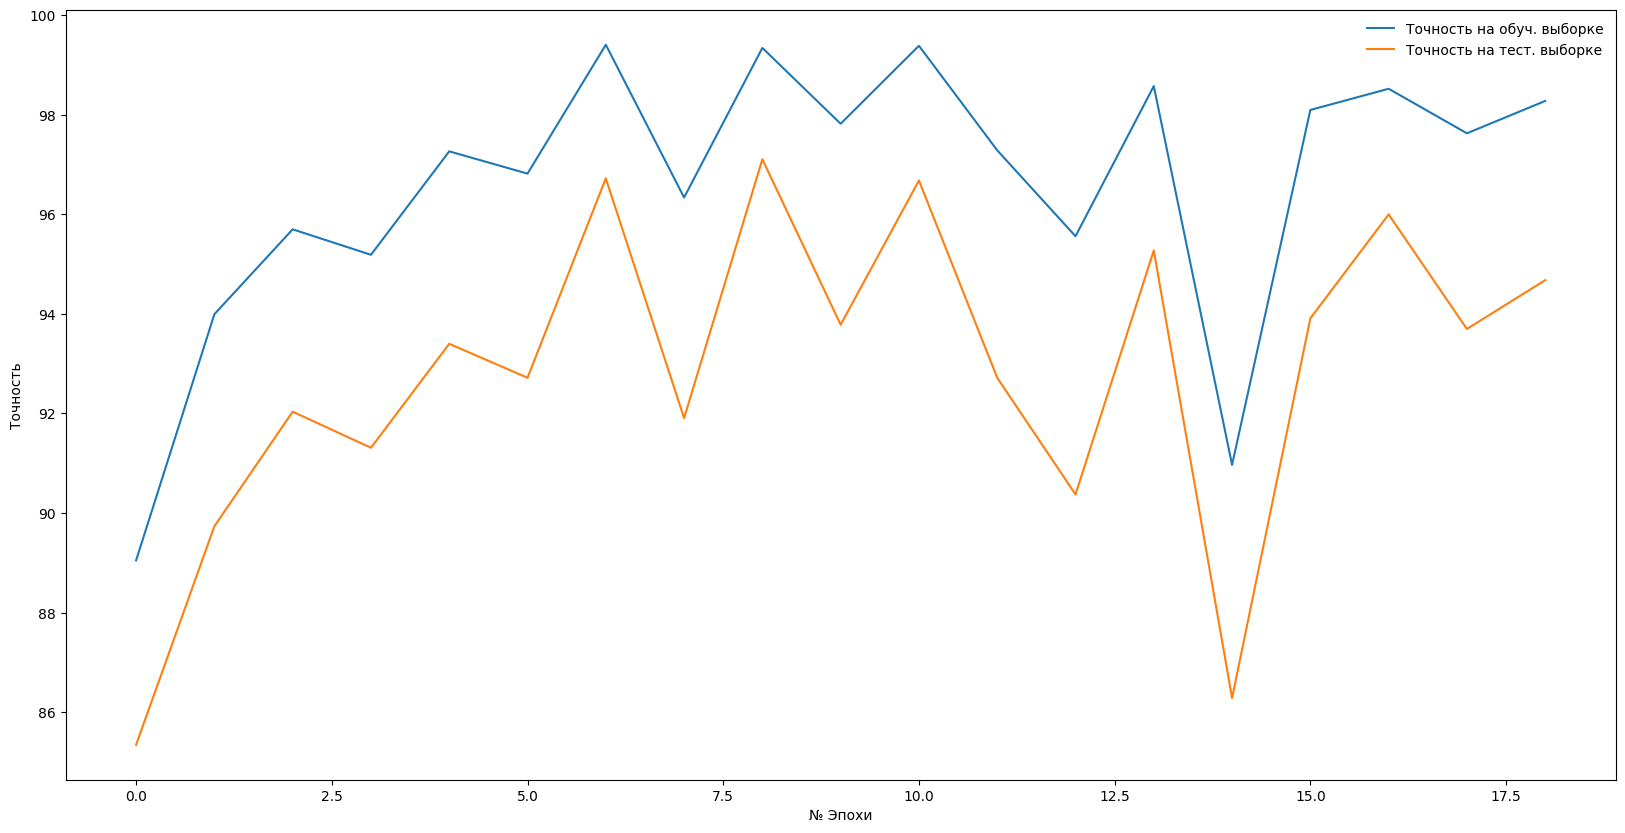

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

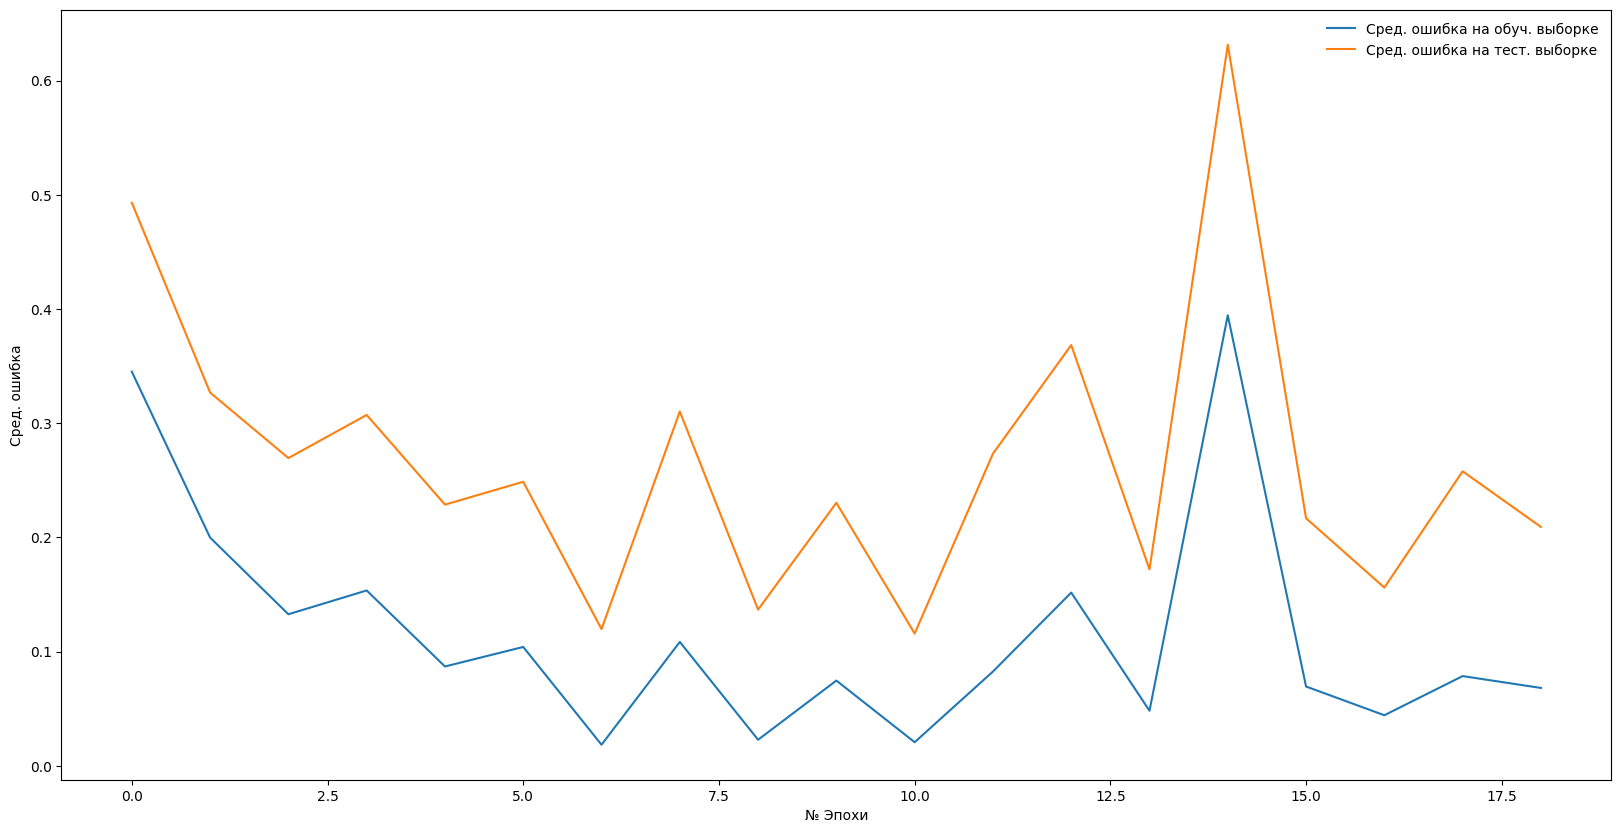

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


In [ ]:
preds=[]
trgts=[]
with torch.no_grad():
  for data in tqdm(test_loader):
    inputs, targets=data[0].to(device),data[1].to(device)
    outputs=model(inputs)
    targets=targets.to('cpu').numpy()
    pred = outputs.data.max(1, keepdim=True)[1]
    pred = pred.to('cpu').numpy()
    trgts.append(targets)
    preds.append(pred)

  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
targets=[x for sub in trgts for x in sub]
predictions=[x[0] for sub in preds for x in sub]
targets=np.array(targets)
predictions=np.array(predictions)

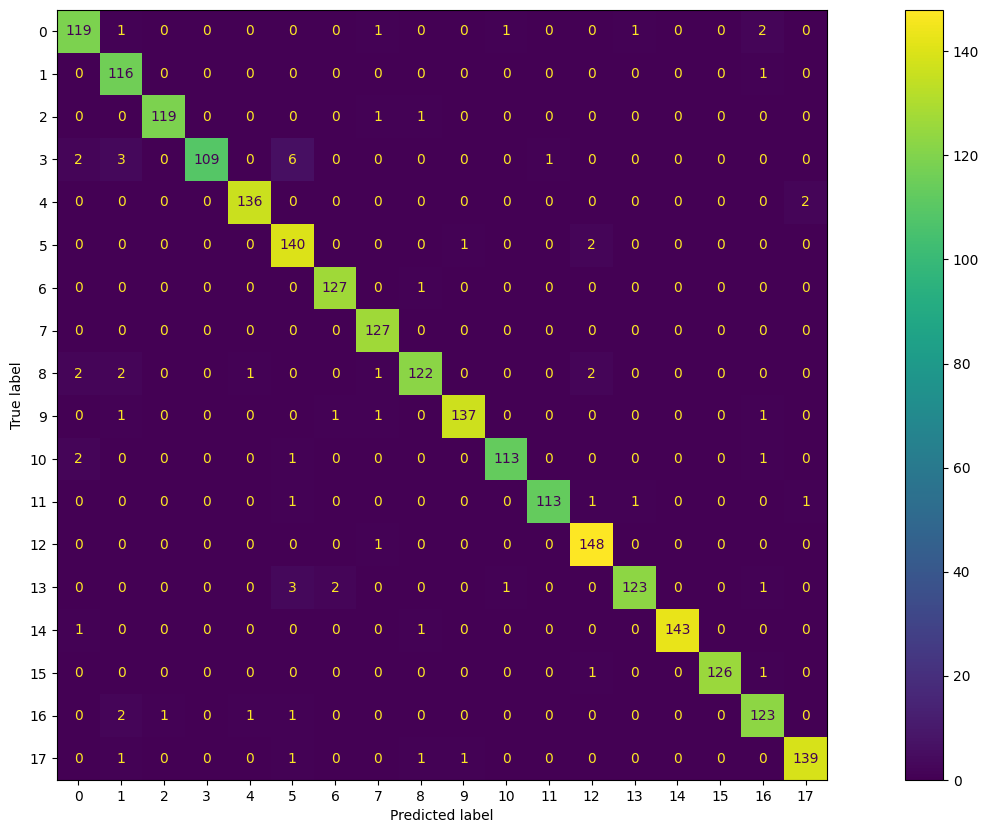

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
f1_score(targets, predictions,average='micro')

0.9710391822827938